# electron selection efficiency as a function of  calorimetry variables
using single-particle $e$- and $\pi$-gun simulations from build fb01759 and 419662c

last edit Sep-9,2021

In [1]:
from IPython.display import display
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import sys; sys.path.insert(0, '/Users/erezcohen/Desktop/Software/mySoftware/Python/'); 
from my_tools               import *; 
from plot_tools             import *;
from my_data_analysis_tools import *;
%config InlineBackend.figure_format = 'retina'
main_data_path = '/Users/erezcohen/Desktop/data/BAND/AnalysisCSVfiles/'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

# (1) load data sets

In [2]:
main_data_path = '/Users/erezcohen/Desktop/data/EIC/ECCE/ElectronPionPID/EvalFiles/CSVfiles/';
e_color = 'k';
pi_color='royalblue';

In [3]:
e_data,pi_data = dict(),dict()

## (1.1) CEMC includes a lot of data, so load only partial data from the CEMC

🚜>wc -l singleElectron_cemc_ntp_cluster.csv 

 571343204 
 
 🚜>wc -l singlePion_cemc_ntp_cluster.csv 
 
 573035068 

In [4]:
nrowsCEMC = 10000000
for filelabel,chainname in zip(['cemc'],
                               ['ntp_cluster']):
    e_data[filelabel] = pd.read_csv(main_data_path + 'singleElectron_'
                                    +filelabel+'_'+chainname+'.csv', nrows=nrowsCEMC);
    pi_data[filelabel] = pd.read_csv(main_data_path + 'singlePion_'
                                     +filelabel+'_'+chainname+'.csv', nrows=nrowsCEMC);
    print ('loaded',len(e_data[filelabel]),'clusters )electrons and',len(pi_data[filelabel]),'clusters pions from',filelabel)

loaded 10000000 clusters )electrons and 10000000 clusters pions from cemc


## (1.2) load all information from hcalin/out, fhcal/femc, and tracking

In [5]:
for filelabel,chainname in zip(['hcalin','hcalout','fhcal','femc','tracking'],
                               ['ntp_cluster','ntp_cluster','ntp_cluster','ntp_cluster','tracks']):
    e_data[filelabel] = pd.read_csv(main_data_path + 'singleElectron_'+filelabel+'_'+chainname+'.csv');
    pi_data[filelabel] = pd.read_csv(main_data_path + 'singlePion_'+filelabel+'_'+chainname+'.csv');
    print ('loaded',len(e_data[filelabel]),'electrons and',len(pi_data[filelabel]),'pions in',filelabel)

loaded 267359 electrons and 677503 pions in hcalin
loaded 251642 electrons and 1293712 pions in hcalout
loaded 64433 electrons and 551465 pions in fhcal
loaded 386557 electrons and 840209 pions in femc
loaded 903000 electrons and 902000 pions in tracking


### remove lines from tracking which we have no information about (trackID=-9999)

In [6]:
e_data['tracking'] = e_data['tracking'][e_data['tracking']['trackID']!=-9999]
pi_data['tracking'] = pi_data['tracking'][pi_data['tracking']['trackID']!=-9999]

## (1.3) Merge information from CEMC and tracking
To obtain reconstructed momentum information

### (1.3.1) Threshold minimal energy in cluster 

In [28]:
EclusterMin = 0.1 # GeV
eta_min     = -0.88
eta_max     = 0.88

In [29]:
e_data['cemc']  = e_data['cemc'] [(e_data['cemc']['e']>EclusterMin) 
                                  & (eta_min <= e_data['cemc']['eta'])  & (e_data['cemc']['eta'] <= eta_max)]
pi_data['cemc'] = pi_data['cemc'][(pi_data['cemc']['e']>EclusterMin)
                                  & (eta_min <= pi_data['cemc']['eta']) & (pi_data['cemc']['eta'] <= eta_max)]
e_data['cemc'][0:10]

,run,event,clusterID,eta,x,y,z,e,phi,Unnamed: 9
257,930000,0,257,-0.585674,83.4744,-45.8509,-55.9023,2.040140,-0.502291,NaN
503,930000,0,503,0.785324,-65.6895,-68.9877,85.8636,0.113227,-2.331710,NaN
1137,930000,1,516,0.875424,34.5575,88.7530,92.6038,0.107051,1.199490,NaN
1470,930000,2,236,-0.795175,16.3925,93.8197,-82.4758,9.412250,1.397820,NaN
1494,930000,2,260,-0.676516,-30.0561,90.3713,-67.9623,0.113227,1.891870,NaN
1510,930000,2,276,-0.636089,-80.7496,50.5362,-63.2646,0.121462,2.582390,NaN
2463,930000,3,578,0.838949,14.9769,94.0675,88.4993,4.354090,1.412910,NaN
3484,930000,5,233,-0.807189,70.8537,63.6533,-81.7927,0.109110,0.731918,NaN
3591,930000,5,340,-0.304962,-92.4067,-23.0496,-25.7757,0.113227,-2.897140,NaN
3683,930000,5,432,0.081017,-88.8978,34.1679,11.4440,0.113227,2.774650,NaN


In [30]:
elec_data,pion_data = dict(),dict()
for filelabel in ['cemc']:
    elec_data[filelabel] = pd.merge(e_data['tracking'], e_data[filelabel],
                                    on=['run','event'],
                                    suffixes=('_tracking','_hcalin'))

    pion_data[filelabel] = pd.merge(pi_data['tracking'], pi_data[filelabel],
                                    on=['run','event'],
                                    suffixes=('_tracking','_hcalin'))

    print('done merging',filelabel,'with',filelabel,'data')

done merging cemc with cemc data


# (2) Sum over the energy of all clusters belonging to the same event (single-particle)
and define additional kinematic variables that we want

In [31]:
elec_data['cemc'][0:3]#[['run','event','clusterID','e','px']]

,run,event,trackID,charge,nhits,px,py,pz,pcax,pcay,...,dca2d,Unnamed: 12,clusterID,eta,x,y,z,e,phi,Unnamed: 9
0,865000.0,3,0,-1,0,-0.000897,0.317721,-2.792230,0.000562,0.003683,...,0.000784,NaN,376,0.087892,-95.2289,1.5343,7.12931,5.401960,3.12548,NaN
1,865000.0,3,0,-1,0,-0.000897,0.317721,-2.792230,0.000562,0.003683,...,0.000784,NaN,515,0.870061,25.0019,91.8980,92.45960,0.137931,1.30516,NaN
2,865000.0,4,0,-1,0,-6.281240,0.319865,0.556036,0.008561,-0.000802,...,0.002877,NaN,322,-0.441929,-13.3298,-94.3075,-42.59650,14.943900,-1.71121,NaN


In [32]:
el_grouped,pi_grouped = dict(),dict()

for filelabel in ['cemc']:
    el_cluster_group = elec_data['cemc'].groupby(['run','event'])    
    el_grouped[filelabel] = pd.DataFrame({'run':np.array(el_cluster_group['run'].mean()),
                                         'event':np.array(el_cluster_group['event'].mean()),
                                         '$p_x$':np.array(el_cluster_group['px'].mean()),
                                         '$p_y$':np.array(el_cluster_group['py'].mean()),
                                         '$p_z$':np.array(el_cluster_group['pz'].mean()),                                        
                                         '$\\sum{E}_{cluster}$':np.array(el_cluster_group['e'].sum()),                                        
                                         '$\\bar{\\eta}_{cluster}$':np.array(el_cluster_group['eta'].mean()),                                                                                
                                         '$\\bar{x}_{cluster}$':np.array(el_cluster_group['x'].mean()),                                        
                                         '$\\bar{y}_{cluster}$':np.array(el_cluster_group['y'].mean()),                                        
                                         '$\\bar{z}_{cluster}$':np.array(el_cluster_group['z'].mean())
                                        })
    display(el_grouped[filelabel])
    
    pi_cluster_group = pion_data['cemc'].groupby(['run','event'])    
    pi_grouped[filelabel] = pd.DataFrame({'run':np.array(pi_cluster_group['run'].mean()),
                                         'event':np.array(pi_cluster_group['event'].mean()),
                                         '$p_x$':np.array(pi_cluster_group['px'].mean()),
                                         '$p_y$':np.array(pi_cluster_group['py'].mean()),
                                         '$p_z$':np.array(pi_cluster_group['pz'].mean()),                                        
                                         '$\\sum{E}_{cluster}$':np.array(pi_cluster_group['e'].sum()),                                        
                                         '$\\bar{\\eta}_{cluster}$':np.array(pi_cluster_group['eta'].mean()),                                                                                
                                         '$\\bar{x}_{cluster}$':np.array(pi_cluster_group['x'].mean()),                                        
                                         '$\\bar{y}_{cluster}$':np.array(pi_cluster_group['y'].mean()),                                        
                                         '$\\bar{z}_{cluster}$':np.array(pi_cluster_group['z'].mean())
                                        })
    display(pi_grouped[filelabel])    

,run,event,$p_x$,$p_y$,$p_z$,$\sum{E}_{cluster}$,$\bar{\eta}_{cluster}$,$\bar{x}_{cluster}$,$\bar{y}_{cluster}$,$\bar{z}_{cluster}$
0,133000.0,1.0,1.234150,-1.308090,-18.556000,0.214102,0.396113,-26.152650,47.892550,37.379805
1,133000.0,3.0,-1.145300,3.690400,-10.151100,0.209985,-0.209650,31.222150,0.002750,-18.456400
2,133000.0,4.0,-1.701600,1.092910,-9.272760,1.189910,-0.695408,-85.757000,-41.447300,-67.327200
3,133000.0,5.0,-0.978842,-0.244582,-0.747967,0.121462,0.793242,-63.925300,70.597200,85.581200
4,133000.0,6.0,-0.362510,0.143041,3.568880,0.207926,0.101521,-82.913900,-1.914600,7.132150
...,...,...,...,...,...,...,...,...,...,...
9695,942000.0,991.0,0.098881,-0.562775,8.526280,5.152860,0.559582,21.005200,92.896200,60.363800
9696,942000.0,993.0,-0.430336,-0.762669,4.946860,0.129696,0.288311,93.256000,-19.444000,25.205500
9697,942000.0,997.0,-0.100784,-1.305440,-8.758030,2.466291,0.262254,-21.433433,-79.094267,26.828013
9698,942000.0,998.0,-2.105060,-1.172920,0.102601,0.129696,0.029979,76.309400,56.987100,0.808845


,run,event,$p_x$,$p_y$,$p_z$,$\sum{E}_{cluster}$,$\bar{\eta}_{cluster}$,$\bar{x}_{cluster}$,$\bar{y}_{cluster}$,$\bar{z}_{cluster}$
0,115000.0,1.0,0.232261,-0.078153,2.048880,13.791011,0.364932,36.360240,-84.484000,32.480020
1,115000.0,2.0,3.625630,-11.893500,4.276450,0.518785,-0.280439,46.845350,-14.571400,-28.605250
2,115000.0,3.0,3.640750,3.682430,-11.217900,0.545549,-0.811191,-30.259200,-90.302750,-88.358650
3,115000.0,4.0,-3.328050,-10.423800,-9.680630,0.107051,-0.163600,77.300400,-55.632000,-16.785600
4,115000.0,7.0,1.354390,2.058380,-16.240400,0.100875,0.613881,-22.631000,-92.519300,67.035900
...,...,...,...,...,...,...,...,...,...,...
10135,964000.0,991.0,-0.042565,0.507508,3.768070,9.631096,0.140555,-82.635771,-46.153986,17.563897
10136,964000.0,994.0,-2.183190,1.149950,15.345500,0.259393,-0.392587,20.498650,-12.117800,-37.573950
10137,964000.0,995.0,6.034930,-2.296100,16.063700,0.329388,0.182511,76.446850,-8.999300,14.766250
10138,964000.0,996.0,6.114390,3.666020,-0.550524,0.543489,-0.279967,60.664675,5.051903,-25.870405


In [33]:
for filelabel in ['cemc']:#,'femc','hcalin','hcalout','el_grouped']:
    el_grouped[filelabel]['$p$']  = np.sqrt( np.square(el_grouped[filelabel]['$p_x$'])                                            
                                         + np.square(el_grouped[filelabel]['$p_y$'])                                          
                                         + np.square(el_grouped[filelabel]['$p_z$']))
    pi_grouped[filelabel]['$p$'] = np.sqrt( np.square(pi_grouped[filelabel]['$p_x$'])                                            
                                         + np.square(pi_grouped[filelabel]['$p_y$'])                                          
                                         + np.square(pi_grouped[filelabel]['$p_z$']))
    el_grouped[filelabel]['$E/p$'] = el_grouped[filelabel]['$\\sum{E}_{cluster}$']/el_grouped[filelabel]['$p$']
    pi_grouped[filelabel]['$E/p$'] = pi_grouped[filelabel]['$\\sum{E}_{cluster}$']/pi_grouped[filelabel]['$p$']    

# auxiliary functions

In [34]:
def Plot_e_and_pi_distribtions(chainname='hcalin',chainlabel='calin',
                               variable='e',varlabel='$\Delta E_{dep}$',varunits='[GeV]',
                               elec_data=el_grouped,pion_data=pi_grouped,
                               bins=np.linspace(0,2.,51),
                               ax=None, xticks=None, 
                               ylabel='Frequency [a.u.]', 
                               do_add_legend=True, yscale='log', fontsize=18,xlim=None):
    
    if ax is None: fig,ax = plt.subplots(figsize=(9,6))
    if '|' in variable: # take absolute value, e.g. |z|
        e_arr  = np.abs(elec_data[chainname][variable[1:-1]]);
        pi_arr = np.abs(pion_data[chainname][variable[1:-1]]);        
        varlabel = '|' + varlabel + '|';
    else:
        e_arr  = elec_data[chainname][variable];
        pi_arr = pion_data[chainname][variable];

    e_hist,edges  = np.histogram( e_arr,  bins=bins, density=True )
    pi_hist,edges = np.histogram( pi_arr, bins=bins, density=True )
    x = (edges[1:]+edges[:-1])/2
    
    ax.step( x, e_hist, color=e_color  , where='mid', linewidth = 2 , label='$e$')#, label='$e$, %.1fM evnets'%(len(e_data[chainname])*1e-6));
    ax.step( x, pi_hist, color=pi_color, where='mid', linewidth = 2 , label='$\pi$')#, label='$\pi$, %.1fM evnets'%(len(pi_data[chainname])*1e-6));
    
    set_axes(ax,
             varlabel + ' ' + varunits,ylabel,
             title = varlabel + ' in ' + chainlabel,
             do_add_grid=True,xticks=xticks, do_add_legend=do_add_legend,
             fontsize=fontsize,xlim=xlim)
    ax.set_yscale(yscale)
    plt.tight_layout()
    

In [35]:
def get_cut_efficiency(x, min_or_max, x_cut):
    '''
    compute selection efficiency of a given (min/max) 1D cut on x
    Uncertainty estimated assuming Poissonian uncertainty
    and bound from below by 0, and from above by eff_max=1
    
    input
    --------
    min_or_max     'min' / 'max'
    
    return
    --------
    eff, eff_err_dw, eff_err_up
    
    '''
    
    if min_or_max=='min':   N_in_cut= float(len( x [x_cut < x]));
    elif min_or_max=='max': N_in_cut= float(len( x [x < x_cut]));
        
    N_tot      = float(len(x))
    eff        = N_in_cut/N_tot
    
    if N_in_cut:  
        eff_err= eff * np.sqrt( 1./N_in_cut + 1./N_tot ) 
    else:
        eff_err= 1./N_tot
        
    eff_err_dw = eff_err;
    eff_err_up = eff_err;
    
    if eff_err_dw > eff_err:   eff_err_dw = eff_err;
    if eff_err_up > 1-eff_err: eff_err_up = 1.-eff_err;
        
    return eff, eff_err_dw, eff_err_up

In [36]:
def plot_1D_variable_and_cut(chainname='hcalin',chainlabel='calin',
                               variable='e',varlabel='$\Delta E_{dep}$',varunits='[GeV]',                                                            
                             elec_data=el_grouped,pion_data=pi_grouped,
                               bins=np.linspace(0,2.,51),
                               xticks=None, min_or_max='min',
                                cut_values=np.linspace(0,2.,10),
                               do_add_legend=True, yscale='log', fontsize=18,xlim=None,ylim=None,
                             figsize=(14,6)):
    
    figure = plt.figure(figsize=figsize)
    ax = figure.add_subplot(1,2,1);
    Plot_e_and_pi_distribtions(chainname=chainname,chainlabel=chainlabel,
                               elec_data=elec_data,pion_data=pion_data,
                               variable=variable,varlabel=varlabel,varunits=varunits,
                               bins=bins,
                               ax=ax, xticks=xticks, 
                               ylabel='Frequency [a.u.]', 
                               do_add_legend=True, yscale='log', fontsize=fontsize,xlim=xlim)

    ax = figure.add_subplot(1,2,2)
    Plot_e_and_pi_1D_cut_impact(chainname=chainname,chainlabel=chainlabel,
                               elec_data=elec_data,pion_data=pion_data,                                
                                variable=variable,varlabel=varlabel,varunits=varunits,
                                min_or_max=min_or_max,
                                cut_values=cut_values,
                                ax=ax, xticks=xticks, 
                                ylabel='Selection efficiency', 
                                do_add_legend=True, yscale='linear', fontsize=fontsize,
                                xlim=(np.min(cut_values)-0.1,np.max(cut_values)),
                                ylim=ylim)
    plt.tight_layout()

In [37]:
def Plot_e_and_pi_1D_cut_impact(chainname='hcalin',chainlabel='calin',
                                variable='e',varlabel='$\Delta E_{dep}$',varunits='[GeV]',
                               elec_data=el_grouped,pion_data=pi_grouped,                                
                                min_or_max='min',
                                cut_values=np.linspace(0,2.,10),
                                ax=None, xticks=None, 
                                ylabel='Selection efficiency', 
                                do_add_legend=True, yscale='linear', fontsize=18,xlim=None,ylim=None):
    
    if ax is None: fig,ax = plt.subplots(figsize=(9,6))

    if '|' in variable:
        e_arr  = np.abs(elec_data[chainname][variable[1:-1]]);
        pi_arr = np.abs(pion_data[chainname][variable[1:-1]]);        
        varlabel = '|' + varlabel + '|';
    else:
        e_arr  = elec_data[chainname][variable];
        pi_arr = pion_data[chainname][variable];
        
    e_eff,  e_eff_err_dw,  e_eff_err_up  = [],[],[]
    pi_eff, pi_eff_err_dw, pi_eff_err_up = [],[],[]
    
    for cut_value in cut_values:#{
        e_eff_in_cut, e_eff_in_cut_err_dw, e_eff_in_cut_err_up    = get_cut_efficiency(e_arr , min_or_max, cut_value)
        pi_eff_in_cut, pi_eff_in_cut_err_dw, pi_eff_in_cut_err_up = get_cut_efficiency(pi_arr, min_or_max, cut_value)
        
        e_eff        .append( e_eff_in_cut         )
        e_eff_err_dw .append( e_eff_in_cut_err_dw  )
        e_eff_err_up .append( e_eff_in_cut_err_up  )

        pi_eff       .append( pi_eff_in_cut        )
        pi_eff_err_dw.append( pi_eff_in_cut_err_dw )
        pi_eff_err_up.append( pi_eff_in_cut_err_up )
    #}
    e_eff,  e_eff_err_dw,  e_eff_err_up  = np.array(e_eff),  np.array( e_eff_err_dw),  np.array( e_eff_err_up)
    pi_eff, pi_eff_err_dw, pi_eff_err_up = np.array(pi_eff), np.array( pi_eff_err_dw), np.array( pi_eff_err_up)
    
    ax.errorbar( cut_values, e_eff, [e_eff_err_dw,e_eff_err_up], marker='o',color=e_color,
                markeredgewidth = 0.2,
                markeredgecolor='k', capsize=3, capthick=3, linestyle = 'None', label='$e$ selection efficiency');
    ax.fill_between( cut_values, e_eff - e_eff_err_dw, e_eff + e_eff_err_up , color=e_color, alpha=0.1)
    ax.errorbar( cut_values, pi_eff, [pi_eff_err_dw,pi_eff_err_up], marker='o',color=pi_color,
                markeredgewidth = 0.2,
                markeredgecolor='k', capsize=3, capthick=3, linestyle = 'None', label='$\pi$ selection efficiency');
    ax.fill_between( cut_values, pi_eff - pi_eff_err_dw, pi_eff + pi_eff_err_up , color=pi_color, alpha=0.1)


    set_axes(ax,min_or_max + ' ' + varlabel + ' ' + varunits,
             ylabel,
             title = 'cut on ' + min_or_max + ' ' + varlabel + ' in ' + chainlabel,
             do_add_grid = True,
             xticks=xticks, do_add_legend=do_add_legend,
             fontsize=fontsize,xlim=xlim,ylim=ylim)
    ax.set_yscale(yscale)    
    plt.tight_layout()      

In [38]:
def plot_EoverP_vs_P(filelabel,
                     elec_data=el_grouped,pion_data=pi_grouped,                                
                     bins=(np.linspace(0,22,100),
                           np.linspace(0,20,100)),ylim=None):
    #  e_EoverP,e_P,pi_EoverP,pi_P,e_ax,pi_ax = plot_EoverP_vs_P(filelabel)
    
    e_EoverP,e_P   = np.array(elec_data[filelabel]['$E/p$']),np.array(elec_data[filelabel]['$p$'])
    pi_EoverP,pi_P = np.array(pion_data[filelabel]['$E/p$']),np.array(pion_data[filelabel]['$p$'])
    
    
    fig=plt.figure(figsize=(16,6))
    e_ax =fig.add_subplot(1,2,1) 
    plt.hist2d( e_P, e_EoverP, bins=bins, cmap='hot_r' );
    set_axes(e_ax,'$p$ [GeV]','$E/p$',title='electrons in ' +filelabel ,do_add_grid=True, ylim=ylim)

    pi_ax =fig.add_subplot(1,2,2) 
    plt.hist2d( pi_P, pi_EoverP, bins=bins, cmap='hot_r' );
    set_axes(pi_ax,'$p$ [GeV]','',title='pions in ' +filelabel ,do_add_grid=True, remove_ticks_y=True, ylim=ylim)

    plt.tight_layout()
    
    return e_EoverP,e_P,pi_EoverP,pi_P,e_ax,pi_ax

In [39]:
def scatter_EoverP_vs_P(filelabel,
                        elec_data=el_grouped,pion_data=pi_grouped,s=1,alpha=0.5,xlim = None,ylim = None):

    
    e_EoverP,e_P   = np.array(elec_data[filelabel]['$E/p$']),np.array(elec_data[filelabel]['$p$'])
    pi_EoverP,pi_P = np.array(pion_data[filelabel]['$E/p$']),np.array(pion_data[filelabel]['$p$'])
    
    
    fig=plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111)
    plt.scatter( e_P, e_EoverP,   s=s, color='salmon' , label='electrons', alpha=np.max([1,alpha * 3]));
    plt.scatter( pi_P, pi_EoverP, s=s, color='royalblue', label='pions' , alpha=alpha);
    set_axes(ax,'$p$ [GeV]','$\\sum{E}_{cluster}/p$',title='pions and electrons in ' +filelabel ,
             do_add_grid=True, do_add_legend=True,
             xlim=xlim, ylim=ylim)

    plt.tight_layout()
    
    return e_EoverP,e_P,pi_EoverP,pi_P,ax

# (3) Look at $E/p$ distribution

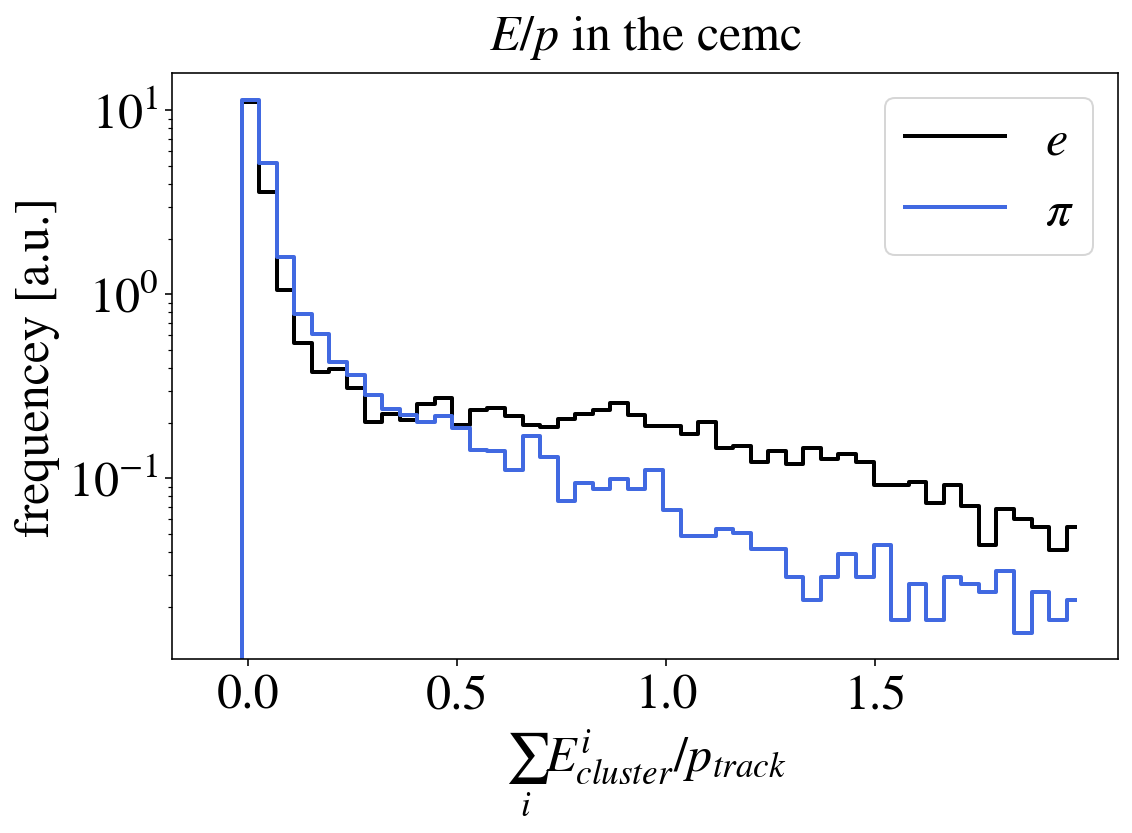

In [40]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
filelabel,chainlabel  = 'cemc', 'cemc'
    
Plot_e_and_pi_distribtions(chainname=filelabel,chainlabel=chainlabel,                              
                           variable='$E/p$',
                           varlabel='$E^{cluster}_{tot}/p$',varunits='',                               
                           bins=np.linspace(-0.1,2,51),                           
                           ax=ax, xticks=None,                            
                           ylabel='Frequency [a.u.]',                            
                           do_add_legend=False, yscale='linear', fontsize=18,xlim=None)

set_axes(ax,'$\\sum_{i}{E^i_{cluster}}/p_{track}$','frequencey [a.u.]',             
         title='$E/p$ in the ' + chainlabel,xticks=(0,0.5,1,1.5),
         remove_ticks_x =False, remove_ticks_y = False,         
         do_add_grid = True,  do_add_legend = True)
ax.set_yscale('log')
ax.grid()

plt.tight_layout()

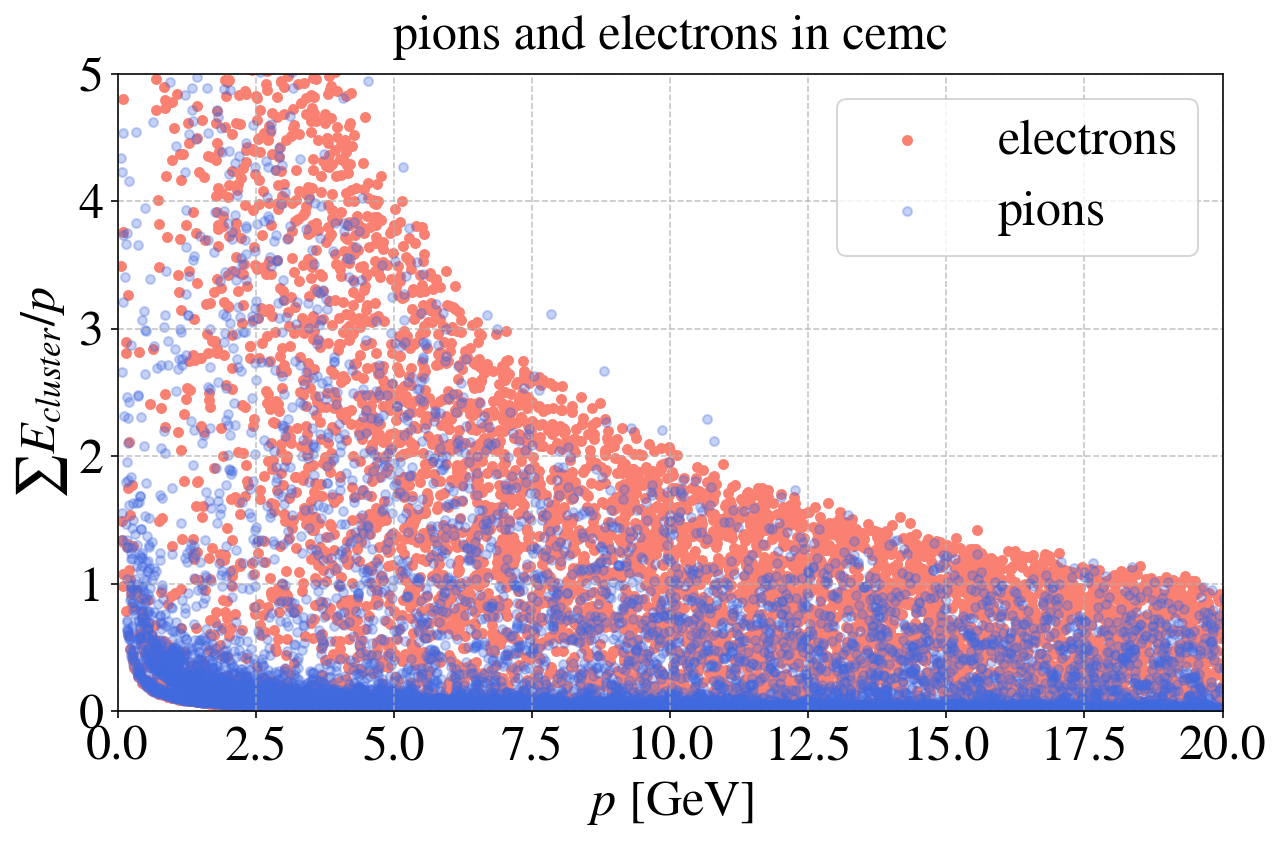

In [20]:
scatter_EoverP_vs_P('cemc',xlim=(0.,20),ylim=(0.,5), s=20, alpha=0.3);

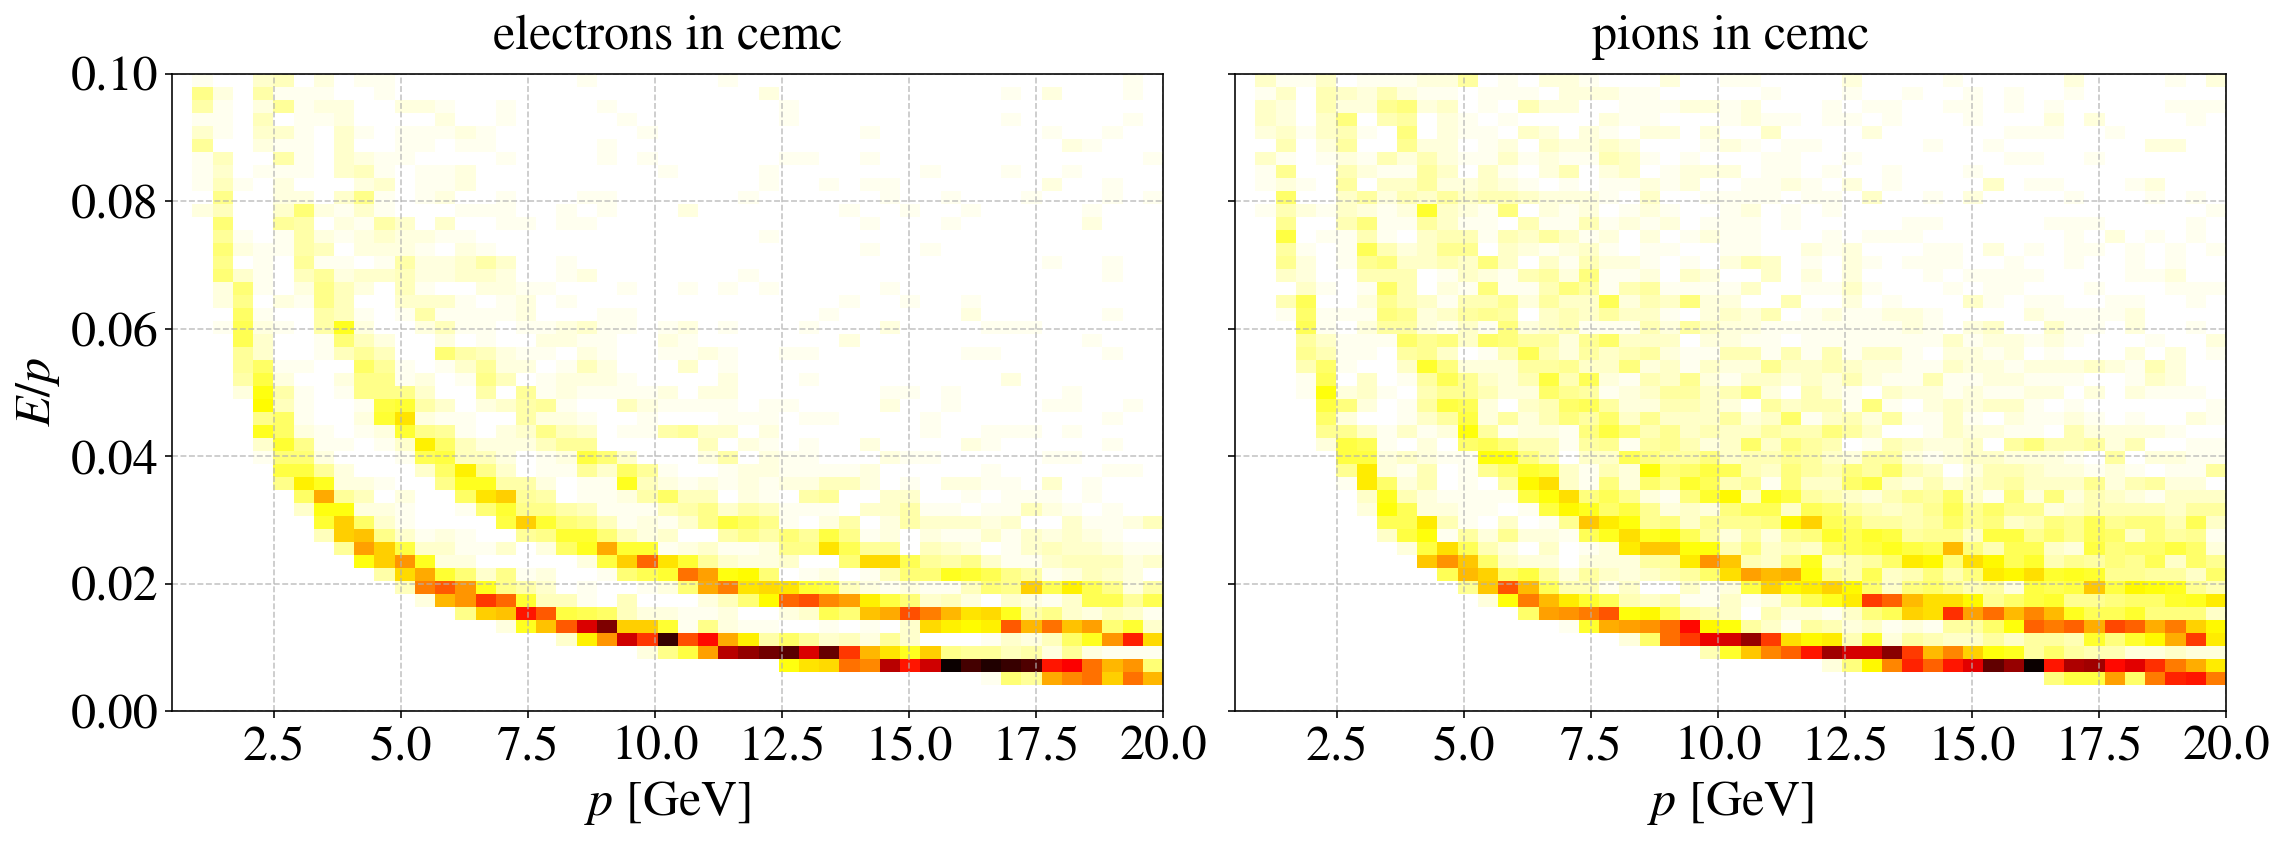

In [21]:
plot_EoverP_vs_P('cemc',
                 bins=(np.linspace(0.5,20,50),np.linspace(0.,.1,50)));

## (3.2) What are the different bands in $E/p$ vs. $p$?

In [22]:
def one_over_x(x,x0,a0,a1,exponent):
    # y = a0 + a1 / x^exponent
    return (a0 + a1 * np.power(x-x0,-exponent))

/var/folders/42/n5_htl9n34j9wpgd5rqsnmv40000gn/T/ipykernel_11472/1038356878.py:3: RuntimeWarning: invalid value encountered in power
  return (a0 + a1 * np.power(x-x0,-exponent))
/var/folders/42/n5_htl9n34j9wpgd5rqsnmv40000gn/T/ipykernel_11472/1038356878.py:3: RuntimeWarning: invalid value encountered in power
  return (a0 + a1 * np.power(x-x0,-exponent))
/var/folders/42/n5_htl9n34j9wpgd5rqsnmv40000gn/T/ipykernel_11472/1038356878.py:3: RuntimeWarning: invalid value encountered in power
  return (a0 + a1 * np.power(x-x0,-exponent))


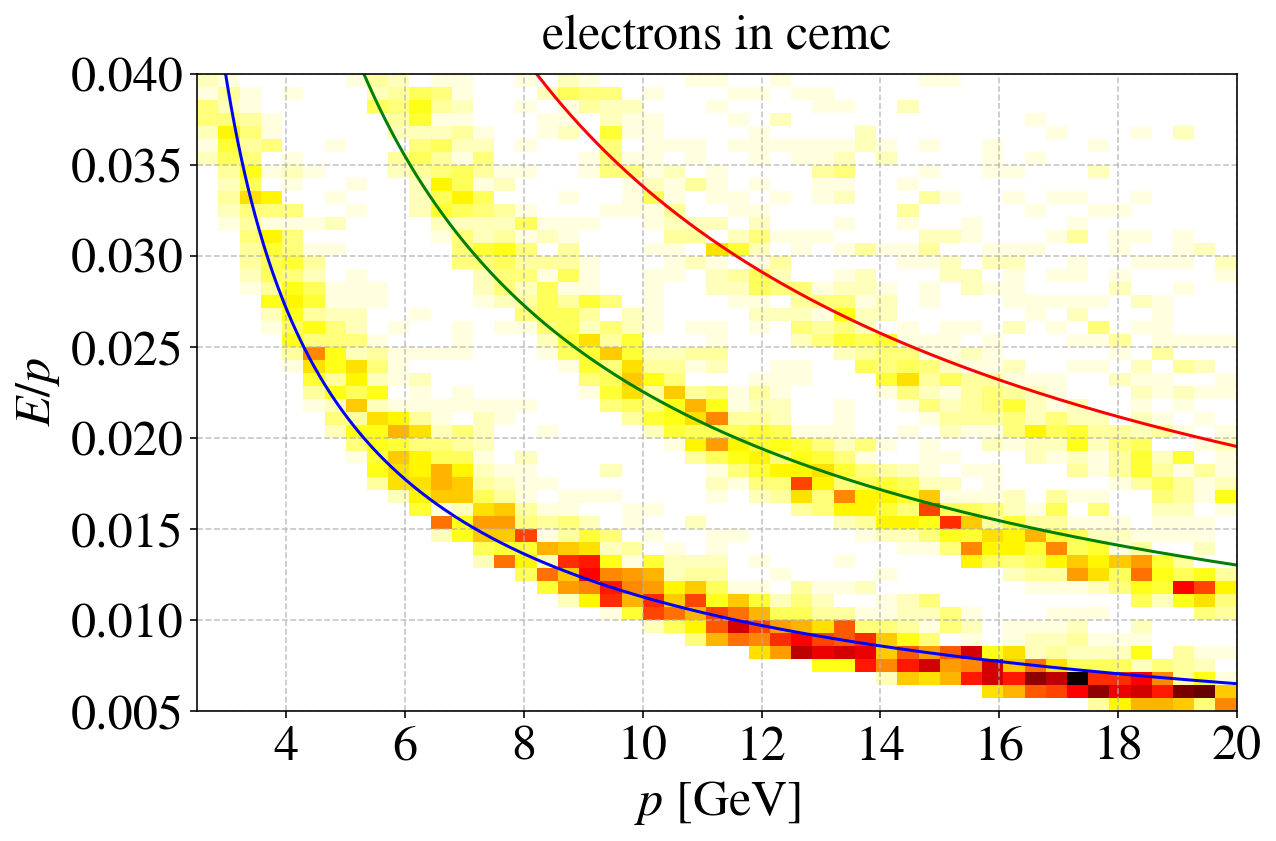

In [23]:
bins=(np.linspace(2.5,20,50),np.linspace(0.005,.04,50))
# x,y = np.array(el_grouped['cemc']['$p$']),np.array(el_grouped['cemc']['$E/p$'])
x,y = np.array(el_grouped['cemc']['$p$']),np.array(el_grouped['cemc']['$E/p$'])
fig=plt.figure(figsize=(9,6))
ax =fig.add_subplot(1,1,1) 
plt.hist2d( x, y, bins=bins, cmap='hot_r' );

x_fit = np.linspace(1.,20,1000);
plt.plot( x_fit, one_over_x( x_fit , 1.6, 0., 0.05, 0.7 ) , '-b' )
plt.plot( x_fit, one_over_x( x_fit , 1.6, 0.0, 0.1, 0.7 ) , '-g' )
plt.plot( x_fit, one_over_x( x_fit , 1.6, 0.0, 0.15, 0.7 ) , '-r' )



set_axes(ax,'$p$ [GeV]','$E/p$',title='electrons in cemc' ,do_add_grid=True)
plt.tight_layout()